In [ ]:
import requests
import pandas as pd
from io import StringIO

# The URL you provided
url = "https://rest.uniprot.org/taxonomy/stream?fields=id%2Cscientific_name%2Crank&format=tsv&query=%28*%29"
# Fetch the data
response = requests.get(url)

# Check if request was successful
if response.status_code == 200:
    # Create a pandas DataFrame from the TSV content
    df = pd.read_csv(StringIO(response.text), sep='\t')
    df.to_csv("../data/rank_tax.csv", index=False)
    print(df.shape)
else:
    print(f"Failed to fetch data: {response.status_code}")

In [10]:
import pandas as pd

df = pd.read_csv("../data/rank_tax.csv")
print(df.head())
df.dropna(inplace = True)
# taxid_idx = {tax_id: idx for idx, tax_id in enumerate(df['Taxon Id'].values)}
# print(len(taxid_idx))


# df.nunique()
tax_ids_rank = {}
rank_tax_ids = {}
for _, r in df.iterrows():
    tax_id = r['Taxon Id']
    rank = r['Rank']
    if tax_id in tax_ids_rank:
        tax_ids_rank[tax_id].append(rank)
    else:    
        tax_ids_rank[tax_id] = [rank]

    if rank in rank_tax_ids:
        rank_tax_ids[rank].append(tax_id)
    else:    
        rank_tax_ids[rank] = [tax_id]
        


/tmp/ipykernel_13652/1532917767.py:3: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/rank_tax.csv")


   Taxon Id           Scientific name          Rank
0         2                  Bacteria  superkingdom
1         6              Azorhizobium         genus
2         7  Azorhizobium caulinodans       species
3         9       Buchnera aphidicola       species
4        10                Cellvibrio         genus


In [11]:
print(len(rank_tax_ids))
print(list(rank_tax_ids.keys()))
sorted_dict = dict(sorted(rank_tax_ids.items(), key=lambda item: len(item[1])))
for k,v in sorted_dict.items():
    print(k, len(v))

44
['superkingdom', 'genus', 'species', 'order', 'family', 'subspecies', 'no rank', 'subfamily', 'strain', 'serogroup', 'biotype', 'tribe', 'phylum', 'class', 'species group', 'forma', 'clade', 'suborder', 'subclass', 'varietas', 'kingdom', 'subphylum', 'forma specialis', 'isolate', 'superfamily', 'infraorder', 'infraclass', 'superorder', 'subgenus', 'superclass', 'parvorder', 'serotype', 'species subgroup', 'subcohort', 'cohort', 'genotype', 'subtribe', 'section', 'series', 'morph', 'subkingdom', 'superphylum', 'subsection', 'pathogroup']
subkingdom 1
superphylum 1
subcohort 3
superkingdom 4
cohort 5
pathogroup 5
superclass 6
series 9
morph 11
kingdom 13
biotype 17
infraclass 19
genotype 22
parvorder 26
subphylum 31
subsection 41
superorder 57
species subgroup 134
infraorder 135
serogroup 154
subclass 169
phylum 311
species group 359
suborder 375
class 534
section 534
subtribe 587
forma 699
forma specialis 784
superfamily 901
clade 956
serotype 1229
isolate 1304
subgenus 1821
order 19

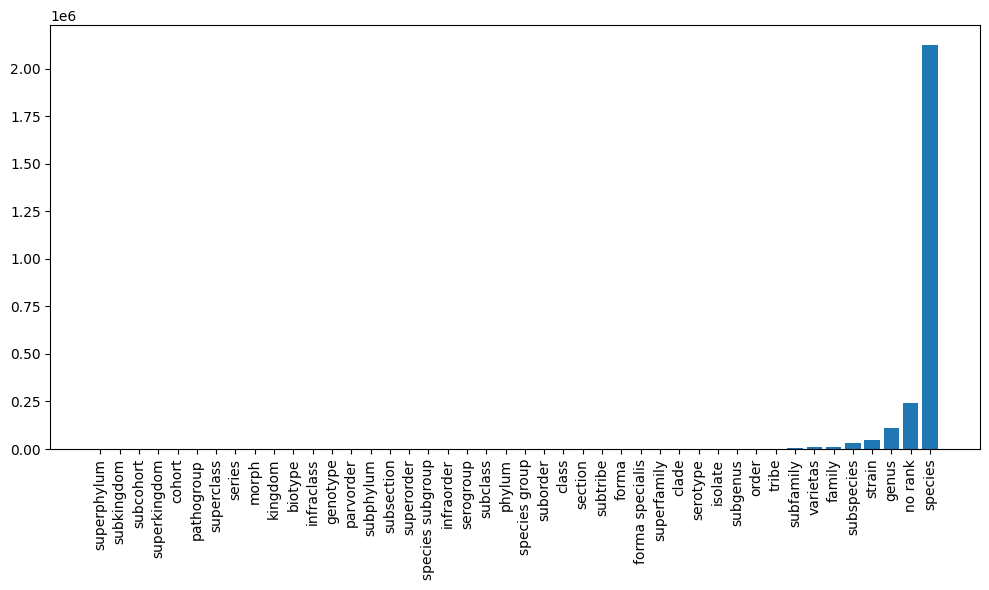

In [21]:
import matplotlib.pyplot as plt
import numpy as np

x = list(rank_tax_ids.keys())
# x.remove("species")
y = [len(rank_tax_ids[i]) for i in x]

# Sort both x and y together based on y values
sorted_indices = np.argsort(y)  # or np.argsort(-y) for descending order
x_sorted = [x[i] for i in sorted_indices]
y_sorted = [y[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))  # Optional: make plot bigger
plt.bar(x_sorted, y_sorted)
plt.xticks(rotation=90)
plt.tight_layout()  # Prevents label cutoff
plt.show()

In [39]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import sys, os, math

sys.path.insert(0, '../dlp')
from data_access import PQDataAccess
from data_process import *

pd.set_option('future.no_silent_downcasting', True)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

batch_size = 1000
da = PQDataAccess("/home/aac/Alireza/datasets/export_pqt_4_taxseq/corpus_1000_random", batch_size)


cuda:0


In [44]:
import os, pickle

rank2name_file = "../data/rank2name.pkl"
name2rank_file = "../data/name2rank.pkl"

# Check if the file exists
if os.path.exists(rank2name_file) and os.path.exists(name2rank_file):
    # Load the dictionary if the file exists
    with open(rank2name_file, "rb") as f:
        rank2name = pickle.load(f)
    with open(name2rank_file, "rb") as f:
        name2rank = pickle.load(f)
    print("Loaded dictionary.")
else:
    df = pd.read_csv("../data/rank_tax.csv")
    df.dropna(inplace = True)
    
    name2rank = {}
    rank2name = {}
    for _, r in df.iterrows():
        name = r['Scientific name']
        rank = r['Rank']

        if name in ["cellular organisms", "other entries", "unclassified entries", "Viruses"]:
            rank = "begining root"
        
        name2rank[name] = rank
    
        if rank in rank2name:
            rank2name[rank].append(name)
        else:    
            rank2name[rank] = [name]
            
    with open(rank2name_file, "wb") as f:
        pickle.dump(rank2name, f)
    with open(name2rank_file, "wb") as f:
        pickle.dump(name2rank, f)
    print("Created and saved dictionary.")

tax_vocab_sizes = {
    k: len(v) for k,v in rank2name.items()
}

# print(tax_vocab_sizes)
# Print tax_vocab_sizes sorted by value (number of taxa per rank)
# sorted_sizes = dict(sorted(tax_vocab_sizes.items(), key=lambda x: x[1], reverse=True))
# print("\nTaxonomic ranks sorted by number of taxa:")
# for rank, size in sorted_sizes.items():
#     print(f"{rank}: {size}")


hierarchy = list(rank2name.keys())
# Assign importance values, starting with higher values for broader ranks
importance_dict = {rank: len(hierarchy) - i for i, rank in enumerate(rank2name.keys())}
# Increase the importance for "no rank" specifically, if needed
importance_dict["begining root"] = 55

level_encoder = {
    k: {name: idx + 1 for idx, name in enumerate(v)}
    for k,v in rank2name.items()
}

level_decoder = {
    k: {idx + 1: name for idx, name in enumerate(v)}
    for k,v in rank2name.items()
}

# Sequence encoder: Convert the protein sequence into integers
def encode_lineage(lineage_str):
    taxes_str = lineage_str.split(", ")
    # print(taxes_str)
    ranks = [name2rank.get(s, "species") for s in taxes_str]
    # print(ranks)
    encoded = {k: [] for k in rank2name.keys()}
    for tax_str, r in zip(taxes_str, ranks):
        encoded[r].append(tax_str)

    return encoded


def data_to_tensor_batch(b):
    tax_ids = [encode_lineage(e['tax_lineage']) for e in b]
    combined_dict = {}
    for d in tax_ids:
        for key, value in d.items():
            combined_dict.setdefault(key, []).extend(value)


Loaded dictionary.
{'superkingdom': 3, 'genus': 109455, 'species': 2122700, 'order': 1915, 'family': 10413, 'subspecies': 29427, 'no rank': 242062, 'subfamily': 3261, 'strain': 46396, 'serogroup': 154, 'biotype': 17, 'tribe': 2393, 'phylum': 311, 'class': 534, 'species group': 359, 'forma': 699, 'clade': 956, 'suborder': 375, 'subclass': 169, 'varietas': 9991, 'kingdom': 13, 'subphylum': 31, 'forma specialis': 784, 'isolate': 1304, 'superfamily': 901, 'infraorder': 135, 'infraclass': 19, 'superorder': 57, 'subgenus': 1821, 'superclass': 6, 'parvorder': 26, 'begining root': 4, 'serotype': 1229, 'species subgroup': 134, 'subcohort': 3, 'cohort': 5, 'genotype': 22, 'subtribe': 587, 'section': 534, 'series': 9, 'morph': 11, 'subkingdom': 1, 'superphylum': 1, 'subsection': 41, 'pathogroup': 5}


In [58]:
rank2name['superkingdom']

['Bacteria', 'Archaea', 'Eukaryota']


Taxonomic ranks sorted by number of taxa:
clade: 257120
species: 246105
begining root: 100000
superkingdom: 97562
genus: 90041
class: 83643
family: 74368
order: 73070
no rank: 44627
phylum: 29957
kingdom: 27083
subphylum: 14926
subclass: 10596
subfamily: 9413
superclass: 8048
strain: 7654
suborder: 7262
infraclass: 7089
subkingdom: 5836
superfamily: 5464
tribe: 4925
superorder: 4842
cohort: 4710
species group: 3867
infraorder: 3074
subgenus: 2042
subtribe: 1377
subspecies: 1231
parvorder: 754
subcohort: 636
species subgroup: 468
varietas: 233
forma specialis: 190
section: 183
series: 165
serotype: 151
isolate: 75
forma: 39
serogroup: 9
biotype: 7
genotype: 7
pathogroup: 6
morph: 0
superphylum: 0
subsection: 0


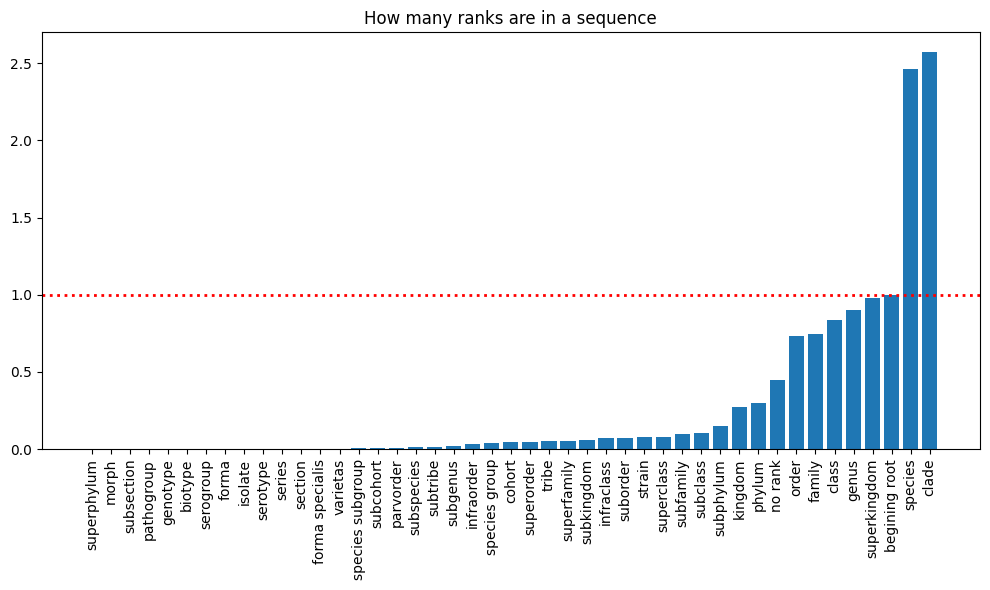

In [50]:
combined_dict = {}
epochs = 100

for i in range(epochs):
    b = da.get_batch()
    tax_ids = [encode_lineage(e['tax_lineage']) for e in b]
    for d in tax_ids:
        for key, value in d.items():
            combined_dict.setdefault(key, []).extend(value)
# print(combined_dict)
tax_vocab_sizes = {k: len(v) for k,v in combined_dict.items()}
# print(tax_vocab_sizes)

# Print tax_vocab_sizes sorted by value (number of taxa per rank)
sorted_sizes = dict(sorted(tax_vocab_sizes.items(), key=lambda x: x[1], reverse=True))
print("\nTaxonomic ranks sorted by number of taxa:")
for rank, size in sorted_sizes.items():
    print(f"{rank}: {size}")

x = list(tax_vocab_sizes.keys())
y = [tax_vocab_sizes[i] / (epochs * 1000) for i in x]

# Sort both x and y together based on y values 
sorted_indices = np.argsort(y)  
x_sorted = [x[i] for i in sorted_indices]
y_sorted = [y[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(x_sorted, y_sorted)

# Add horizontal dotted red line at y=1
plt.axhline(y=1, color='red', linestyle=':', linewidth=2)

plt.xticks(rotation=90)
plt.title("How many ranks are in a sequence")
plt.tight_layout()
plt.show()

In [56]:
epochs = 100
num_total = 0
num_g_zero = {r: 0 for r in rank2name.keys()}
for i in range(epochs):
    b = da.get_batch()
    for e in b:
        num_total += 1
        for r in rank2name.keys():
            if len(encode_lineage(e['tax_lineage'])[r]) > 0:
                num_g_zero[r] += 1

print(num_g_zero)
print(num_total)

{'superkingdom': 97570, 'genus': 80466, 'species': 99835, 'order': 73285, 'family': 74568, 'subspecies': 1217, 'no rank': 39694, 'subfamily': 9378, 'strain': 7584, 'serogroup': 3, 'biotype': 3, 'tribe': 4935, 'phylum': 29557, 'class': 76230, 'species group': 3717, 'forma': 39, 'clade': 69009, 'suborder': 7079, 'subclass': 10480, 'varietas': 248, 'kingdom': 26773, 'subphylum': 14710, 'forma specialis': 192, 'isolate': 62, 'superfamily': 5326, 'infraorder': 3007, 'infraclass': 6802, 'superorder': 4855, 'subgenus': 1449, 'superclass': 8065, 'parvorder': 776, 'begining root': 100000, 'serotype': 142, 'species subgroup': 448, 'subcohort': 611, 'cohort': 4465, 'genotype': 8, 'subtribe': 1369, 'section': 199, 'series': 118, 'morph': 0, 'subkingdom': 5813, 'superphylum': 0, 'subsection': 0, 'pathogroup': 2}
100000


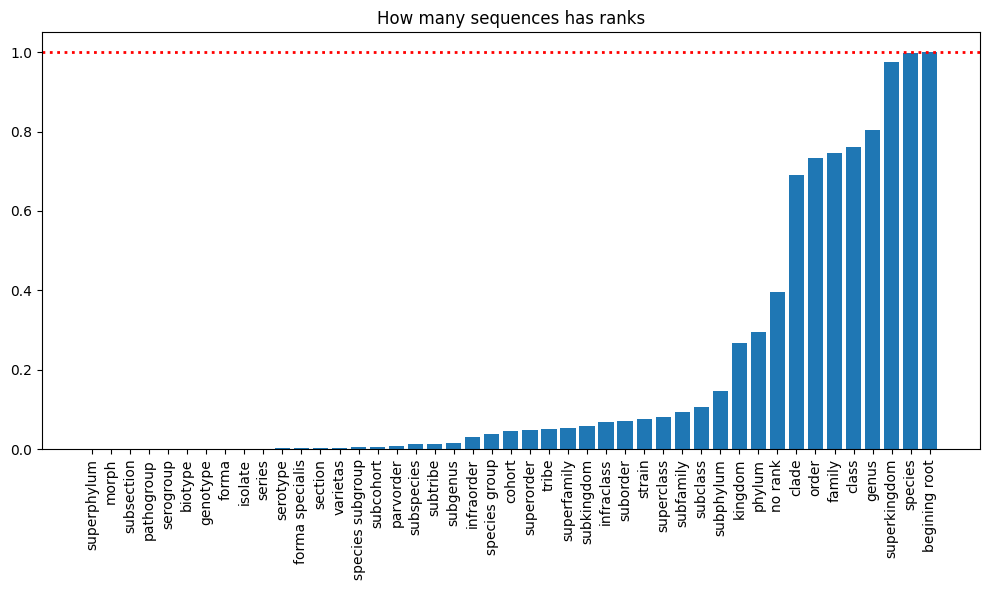

In [57]:
x = list(num_g_zero.keys())
y = [num_g_zero[i] / num_total for i in x]

# Sort both x and y together based on y values 
sorted_indices = np.argsort(y)  
x_sorted = [x[i] for i in sorted_indices]
y_sorted = [y[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(x_sorted, y_sorted)

# Add horizontal dotted red line at y=1
plt.axhline(y=1, color='red', linestyle=':', linewidth=2)

plt.xticks(rotation=90)
plt.title("How many sequences has ranks")
plt.tight_layout()
plt.show()

In [ ]:
level_encoder = {
    k: {name: idx + 1 for idx, name in enumerate(v)}
    for k,v in rank2name.items() if k != "species"
}


# Sequence encoder: Convert the protein sequence into integers
def encode_lineage(lineage_str):
    taxes_str = lineage_str.split(", ")
    ranks = [name2rank[s] for s in lineage_str]
    encoded = {k: [] for k in rank2name.keys() if k != "species"}
    for tax_str, r in zip(taxes_str, ranks):
        encoded[r].append(level_encoder[r].get(tax_str, 0))

    padded_encoded = {k : torch.LongTensor(v + [0 for _ in range(2 - len(v))]) for k,v in rank2name.items() if k!= "species"}
    return padded_encoded


def data_to_tensor_batch(b, model_name):
    if model_name in ["hierarchy", "FNN"]:
        sequences = [encode_sequence(e['sequence']) for e in b]
        tax_ids = [encode_lineage(e['tax_lineage']) for e in b]
        
        return Batch(torch.LongTensor(sequences), tax_ids)


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")
print(len(tokenizer.vocab))

print(tax_lineage.split(", "))
print([name2rank[t] for t in tax_lineage.split(", ")])
lineage_token = tokenizer.encode(tax_lineage.split(", "), add_special_tokens=False, padding='max_length', max_length=40, is_split_into_words= True, return_tensors="pt")
print(lineage_token)

tokenizer.decode(lineage_token[0], skip_special_tokens=True)

In [13]:
import pandas as pd
df = pd.read_csv('../data/Tax.tsv', sep='\t')
for _ in range(11):
    ids_rank = df.iloc[_]['Taxonomic lineage (Ids)'].split(', ')
    ranks = [i.split('(')[1].replace(')', "") for i in ids_rank]
    print(_, ranks)

FileNotFoundError: [Errno 2] No such file or directory: '../data/Tax.tsv'

In [ ]:
df.nunique()


In [ ]:
print(df.shape)
# calculate the number of unique values in each column from Taxonomic lineage (Ids) lists in it
all_tree_trace_ids = []
all_tax_ids = []
for _, r in df.iterrows():
    ids_ranks = r['Taxonomic lineage (Ids)'].split(', ')
    tree_trace_ids = [int(i.split(' ')[0]) for i in ids_ranks] + [int(r['Organism (ID)'])]
    tax_ids = [int(i.split(' ')[0]) for i in ids_ranks]
    all_tax_ids.append(tax_ids)
    all_tree_trace_ids.append(tree_trace_ids)

set_list = [set(t) for t in all_tax_ids]
union_set = len(set().union(*set_list))
print("num_taxonomy_ids: ", union_set)

set_list = [set(t) for t in all_tree_trace_ids]
union_set = len(set().union(*set_list))
print("num_tree_trace_ids: ", union_set)

In [ ]:
tax_ids_pos = {}
pos_tax_ids = {}
for _, r in df.iterrows():
    ids_ranks = r['Taxonomic lineage (Ids)'].split(', ')
    tax_ids = [int(i.split(' ')[0]) for i in ids_ranks]
    for i, tax_id in enumerate(tax_ids):
        if tax_id in tax_ids_pos:
            tax_ids_pos[tax_id].append(i)
        else:    
            tax_ids_pos[tax_id] = [i]

        if i in pos_tax_ids:
            pos_tax_ids[i].append(tax_id)
        else:    
            pos_tax_ids[i] = [tax_id]

print(len(tax_ids_pos))

pos_tax_ids = {k: list(set(v)) for k, v in pos_tax_ids.items()}
print(len(pos_tax_ids))
print(pos_tax_ids[0])

In [ ]:
for k, v in pos_tax_ids.items():
    print(k, len(v))

In [ ]:
# print all ranks of the Organism (ID)s
all_ranks = []
for _, r in df.iterrows():
    organ_id = r['Organism (ID)']
    ranks = [i.split('(')[1].replace(')', "") for i in ids_ranks]
    all_ranks.append(ranks)

In [ ]:
rank_to_id = {}
for _, r in df.iterrows():
    ids_rank = r['Taxonomic lineage (Ids)'].split(', ')
    ranks = [i.split('(')[1].replace(')', "") for i in ids_rank]
    for i, rank in enumerate(ranks):
        if rank not in rank_to_id:
            rank_to_id[rank] = []
        rank_to_id[rank].append(ids_rank[i])

In [ ]:
len(list(rank_to_id.keys()))

In [ ]:
# Convert all lists in the dictionary to sets
rank_to_uniqe_id = {k: len(list(set(v))) for k, v in rank_to_id.items()}

# print(sum([len(v) for v in rank_to_id.values()]))

# Sum values of all sets in the dictionary
# union_set = len(set().union(*rank_to_id.values()))
# print("num_taxonomy_ids: ", union_set)

In [14]:
# plot the number of species in each rank
import matplotlib.pyplot as plt
import numpy as np
x = list(rank_to_id.keys())
y = [len(rank_to_id[i]) for i in x]
plt.bar(x, y)
plt.xticks(rotation=90)
plt.show()


NameError: name 'rank_to_id' is not defined

In [ ]:
import sys
sys.path.insert(0, '../dlp')

from data_process import *

# plot the number of species in each rank
import matplotlib.pyplot as plt
import numpy as np
x = list(rank2name.keys())
x.remove("species")
y = [len(rank2name[i]) for i in x]
plt.bar(x, y)
plt.xticks(rotation=90)
plt.savefig("rank distibution bar")
plt.show()

In [ ]:
import wandb
import random

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="my-awesome-project",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.02,
    "architecture": "CNN",
    "dataset": "CIFAR-100",
    "epochs": 10,
    }
)

# simulate training
epochs = 10
offset = random.random() / 5
for epoch in range(2, epochs):
    acc = 1 - 2 ** -epoch - random.random() / epoch - offset
    loss = 2 ** -epoch + random.random() / epoch + offset

    # log metrics to wandb
    wandb.log({"acc": acc, "loss": loss})

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

In [ ]:
test_protein_sequence = ["MKTAYIAKQRQISFVKSHFSRQDIL"]
src = torch.LongTensor([encode_sequence(*test_protein_sequence)]).to(device)

def test_tokenization():
    sample_lineage = "Bacteria, Proteobacteria, Gammaproteobacteria, Enterobacterales"
    encoded = encode_lineage_tokenizer(sample_lineage)
    
    # Decode to verify
    decoded = tokenizer.decode(encoded)
    
    print("Original:", sample_lineage)
    print("Encoded:", encoded)
    print("Decoded:", decoded)
    print("Start token (CLS):", encoded[0])
    # print("End token (SEP):", encoded[encoded.index(tokenizer.sep_token_id)])
    
    # Get special token IDs for reference
    print("\nSpecial Token IDs:")
    print("CLS token ID:", tokenizer.cls_token_id)
    print("SEP token ID:", tokenizer.sep_token_id)
    print("PAD token ID:", tokenizer.pad_token_id)

test_tokenization()
print(tokenizer.decode([101]))

In [ ]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import sys, os, math

sys.path.insert(0, '../dlp')
from data_access import PQDataAccess
from data_process import *

pd.set_option('future.no_silent_downcasting', True)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

batch_size = 20
da = PQDataAccess("/home/aac/Alireza/datasets/taxseq/corpus_1000", batch_size)

for e in da.get_batch():
    print(e['tax_lineage'])

In [ ]:
from transformers import AutoTokenizer, EsmModel

max_seq_len = 1000

model_name = "esm2_t6_8M_UR50D"

tokenizer = AutoTokenizer.from_pretrained(f"facebook/{model_name}")
model = EsmModel.from_pretrained(f"facebook/{model_name}").to("cuda:0")

def esm_embedding_sequence(sequences):
    inputs = tokenizer(sequences, return_tensors="pt", padding='max_length', truncation=True, max_length=max_seq_len).to("cuda:0")
    
    # Forward pass through the model
    outputs = model(**inputs).last_hidden_state
    
    # Compute mean across the sequence dimension (or any other pooling method)
    output_embeddings = outputs.mean(dim=1).cpu()  # Move back to CPU
    # print(output_embeddings.shape)
    return output_embeddings



import sys
sys.path.insert(0, '../dlp')
from data_access import PQDataAccess

batch_size = 64
da = PQDataAccess("/home/aac/Alireza/datasets/taxseq/corpus_1000", batch_size)



In [ ]:
import torch

def embedding_data_to_tensor_batch(b):
    sequences = [esm_embedding_sequence(e['sequence']) for e in b]
    print(torch.concat(sequences).shape)
    return None

# esm_embedding_sequence('MVMVMMC')
tensor_batch = embedding_data_to_tensor_batch(da.get_batch())


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import sys, os, math
from sklearn.metrics import f1_score, confusion_matrix

sys.path.insert(0, '../dlp')
from data_access import PQDataAccess
from data_process import *
pd.set_option('future.no_silent_downcasting', True)
batch_size = 32
da = PQDataAccess("/home/aac/Alireza/datasets/export_pqt_4_taxseq/corpus_1000_random", batch_size)


In [ ]:
batch = da.get_batch()
sequences = [e['sequence'] for e in batch]
sequences

In [ ]:
tensor_batch = hierarchy_esm_data_to_tensor_batch(da.get_batch())
print(tensor_batch.seq_ids.shape)
print(tensor_batch.taxes)

In [ ]:
print(torch.cuda.memory_summary())

In [ ]:
import torch
import pandas as pd
import sys, os
from transformers import AutoTokenizer, AutoModelForMaskedLM


sys.path.insert(0, '../dlp')
from data_access import PQDataAccess
from data_process import *
pd.set_option('future.no_silent_downcasting', True)
batch_size = 16
da = PQDataAccess("/home/aac/Alireza/datasets/export_pqt_4_taxseq/corpus_1000_random", batch_size)


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

config = "Pubmed"  # Change to "Prot" if you want to use Prot configuration

# Create directories for embeddings
embeddings_dir = f"{config}_embeddings"
if not os.path.exists(embeddings_dir):
    os.makedirs(embeddings_dir)

for split in ['train', 'val', 'test']:
    split_path = os.path.join(embeddings_dir, split)
    if not os.path.exists(split_path):
        os.makedirs(split_path)


tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext")
model = AutoModelForMaskedLM.from_pretrained("microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext")

model.eval()

for split, num_samples in [('train', 10_000), ('val', 1_000), ('test', 1_000)]:
    for i in tqdm(range(num_samples), desc=f"Processing {split}"):
        file_name = os.path.join(embeddings_dir, split, f"{i}.pt")
        if not os.path.isfile(file_name):
            batch = da.get_batch()  # Uncomment if using PQDataAccess
            
            sequences = [e['sequence'] for e in batch]
            inputs = tokenizer(
                sequences,
                return_tensors="pt",
                padding='max_length',
                truncation=True,
                max_length=1000
            ).to(device)

            with torch.no_grad():
                outputs = model(**inputs)

            last_hidden_states = outputs.last_hidden_state.cpu()
            torch.save(last_hidden_states, file_name)
            merged_dict[split].append((last_hidden_states, [e['tax_lineage'] for e in batch]))
            # print(f"Saved ESM embedding {i + 1} for split '{split}'.")

with open("esm_merged.p", "wb") as f:
    pickle.dump(merged_dict, f)
    print("Successfully saved merged ESM embeddings.")


In [ ]:
import pandas as pd

df = pd.read_csv("../data/tax_names.csv").head()
df

In [ ]:
df['Scientific name'].values

In [9]:
embedding = AutoModelForMaskedLM.from_pretrained("microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext")

NameError: name 'AutoModelForMaskedLM' is not defined

In [59]:
import torch
import torch.nn as nn

class DDE(nn.Module):
    def __init__(self):
        super(DDE, self).__init__()
        # Input layer -> Hidden layer
        self.layer1 = nn.Linear(400, 512)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        return x

class Moran(nn.Module):
    def __init__(self):
        super(Moran, self).__init__()
        # Input layer -> Hidden layer
        self.layer1 = nn.Linear(240, 512)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        return x

# Initialize models
dde_model = DDE()
moran_model = Moran()

# Calculate parameters for DDE model
dde_params = sum(p.numel() for p in dde_model.parameters())
print(f"DDE model parameters: {dde_params:,}")

# Calculate parameters for Moran model
moran_params = sum(p.numel() for p in moran_model.parameters())
print(f"Moran model parameters: {moran_params:,}")

# Detailed parameter calculation breakdown
def calculate_linear_params(in_features, out_features):
    weights = in_features * out_features  # Weight matrix
    biases = out_features                # Bias vector
    return weights + biases

# DDE parameter breakdown
dde_layer1_params = calculate_linear_params(400, 512)
print("\nDDE Parameter Breakdown:")
print(f"Layer 1 (400 -> 512): {dde_layer1_params:,} parameters")
print(f"- Weights: {400 * 512:,}")
print(f"- Biases: {512:,}")

# Moran parameter breakdown
moran_layer1_params = calculate_linear_params(240, 512)
print("\nMoran Parameter Breakdown:")
print(f"Layer 1 (240 -> 512): {moran_layer1_params:,} parameters")
print(f"- Weights: {240 * 512:,}")
print(f"- Biases: {512:,}")

DDE model parameters: 205,312
Moran model parameters: 123,392

DDE Parameter Breakdown:
Layer 1 (400 -> 512): 205,312 parameters
- Weights: 204,800
- Biases: 512

Moran Parameter Breakdown:
Layer 1 (240 -> 512): 123,392 parameters
- Weights: 122,880
- Biases: 512


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import EsmModel, BertModel

# 1. LSTM Model
class ProteinLSTM(nn.Module):
    def __init__(self, input_dim=21, embedding_dim=640, hidden_dim=640, num_layers=3):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(hidden_dim * 2, hidden_dim, bias=False)  # *2 for bidirectional
        self.tanh = nn.Tanh()
        self.output_dim = hidden_dim
        
    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        # Weighted sum over all residues (simplified version)
        weights = torch.softmax(torch.ones_like(lstm_out[:,:,0]), dim=1).unsqueeze(-1)
        weighted_sum = (lstm_out * weights).sum(dim=1)
        output = self.linear(weighted_sum)
        return self.tanh(output)

In [18]:
class InferenceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding_mdoel = ProteinLSTM()
        self.linear = nn.Linear(output_dim, hidden_dim)  # *2 for bidirectional
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        x = self.embedding_model(x)
        lstm_out, _ = self.lstm(x)
        print(lstm_out.shape)
        # Weighted sum over all residues (simplified version)
        weights = torch.softmax(torch.ones_like(lstm_out[:,:,0]), dim=1).unsqueeze(-1)
        weighted_sum = (lstm_out * weights).sum(dim=1)
        output = self.linear(weighted_sum)
        print(output.shape)
        return self.tanh(output)

In [20]:
model = ProteinLSTM()
# Calculate parameters for DDE model
dde_params = sum(p.numel() for p in model.parameters())
print(f"DDE model parameters: {dde_params:,}")
print(model)

DDE model parameters: 27,077,760
ProteinLSTM(
  (embedding): Embedding(21, 640)
  (lstm): LSTM(640, 640, num_layers=3, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=1280, out_features=640, bias=False)
  (tanh): Tanh()
)


In [16]:
batch_size = 16
seq_len = 1000
input_tensor = torch.randint(0, 21, size=(16, 1000), dtype=torch.long)
model(input_tensor)

torch.Size([16, 1000, 1280])
torch.Size([16, 1000, 1])
tensor([[[0.0010],
         [0.0010],
         [0.0010],
         ...,
         [0.0010],
         [0.0010],
         [0.0010]],

        [[0.0010],
         [0.0010],
         [0.0010],
         ...,
         [0.0010],
         [0.0010],
         [0.0010]],

        [[0.0010],
         [0.0010],
         [0.0010],
         ...,
         [0.0010],
         [0.0010],
         [0.0010]],

        ...,

        [[0.0010],
         [0.0010],
         [0.0010],
         ...,
         [0.0010],
         [0.0010],
         [0.0010]],

        [[0.0010],
         [0.0010],
         [0.0010],
         ...,
         [0.0010],
         [0.0010],
         [0.0010]],

        [[0.0010],
         [0.0010],
         [0.0010],
         ...,
         [0.0010],
         [0.0010],
         [0.0010]]])
torch.Size([16, 640])


tensor([[ 0.0028,  0.0081, -0.0087,  ..., -0.0308,  0.0206,  0.0190],
        [ 0.0020,  0.0086, -0.0091,  ..., -0.0310,  0.0213,  0.0179],
        [ 0.0026,  0.0082, -0.0106,  ..., -0.0295,  0.0200,  0.0166],
        ...,
        [ 0.0019,  0.0100, -0.0103,  ..., -0.0301,  0.0201,  0.0208],
        [ 0.0032,  0.0075, -0.0109,  ..., -0.0316,  0.0219,  0.0179],
        [ 0.0020,  0.0093, -0.0098,  ..., -0.0312,  0.0206,  0.0184]],
       grad_fn=<TanhBackward0>)